<a href="https://www.kaggle.com/code/dimasat/ps3e19-xgboost-and-nn-for-time-series?scriptVersionId=137841187" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Preparation

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import sklearn
import tensorflow as tf
import xgboost
from xgboost.sklearn import XGBRegressor

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e19/sample_submission.csv
/kaggle/input/playground-series-s3e19/train.csv
/kaggle/input/playground-series-s3e19/test.csv


In [2]:
# Import the train and test datasets
df_train = pd.read_csv("/kaggle/input/playground-series-s3e19/train.csv", index_col = [0])
df_test = pd.read_csv("/kaggle/input/playground-series-s3e19/test.csv", index_col = [0])
df_train

,date,country,store,product,num_sold
id,,,,,
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49
...,...,...,...,...,...
136945,2021-12-31,Spain,Kagglazon,Using LLMs to Improve Your Coding,700
136946,2021-12-31,Spain,Kagglazon,Using LLMs to Train More LLMs,752
136947,2021-12-31,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,111


# Quick Exploration

In [3]:
#Transform from object dtype into datetime
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

#Shows the dataframe general info
df_train.info()
print("\n")
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136950 entries, 0 to 136949
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      136950 non-null  datetime64[ns]
 1   country   136950 non-null  object        
 2   store     136950 non-null  object        
 3   product   136950 non-null  object        
 4   num_sold  136950 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 6.3+ MB


<class 'pandas.core.frame.DataFrame'>
Int64Index: 27375 entries, 136950 to 164324
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     27375 non-null  datetime64[ns]
 1   country  27375 non-null  object        
 2   store    27375 non-null  object        
 3   product  27375 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.0+ MB


In [4]:
#Shows the descriptive statistics for the categorical variables
df_train.describe(include=['O'])

,country,store,product
count,136950,136950,136950
unique,5,3,5
top,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
freq,27390,45650,27390


In [5]:
#Shows the descriptive statistics for the numerical variables
df_train.describe()

,num_sold
count,136950.000000
mean,165.522636
std,183.691575
min,2.000000
25%,46.000000
50%,98.000000
75%,184.000000
max,1380.000000


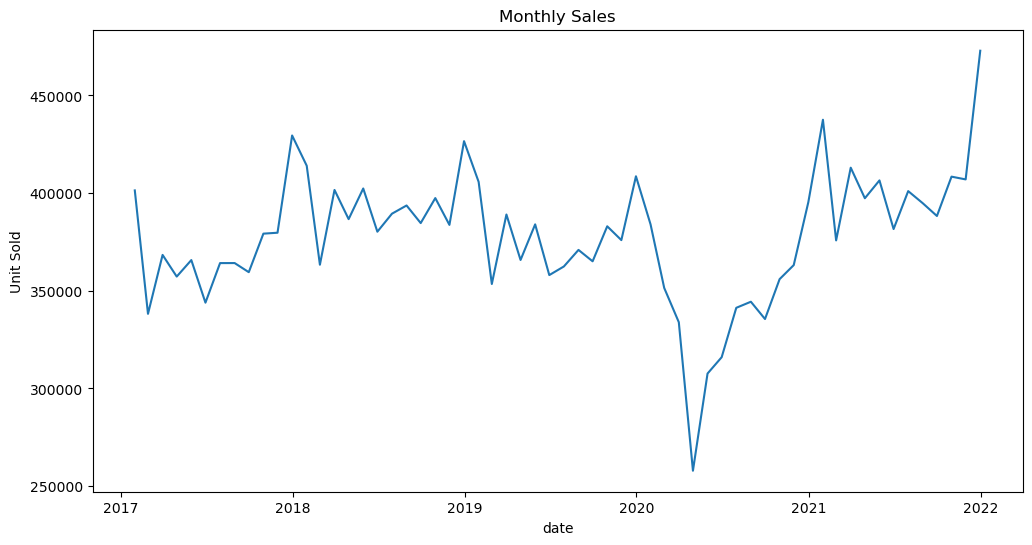

In [6]:
#Plot the monthly-aggregated sales trend over time
monthly = df_train.resample('M', on ='date').sum()['num_sold'].reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(x = monthly['date'], y = monthly['num_sold'])
plt.title('Monthly Sales')
plt.ylabel('Unit Sold')
plt.show()

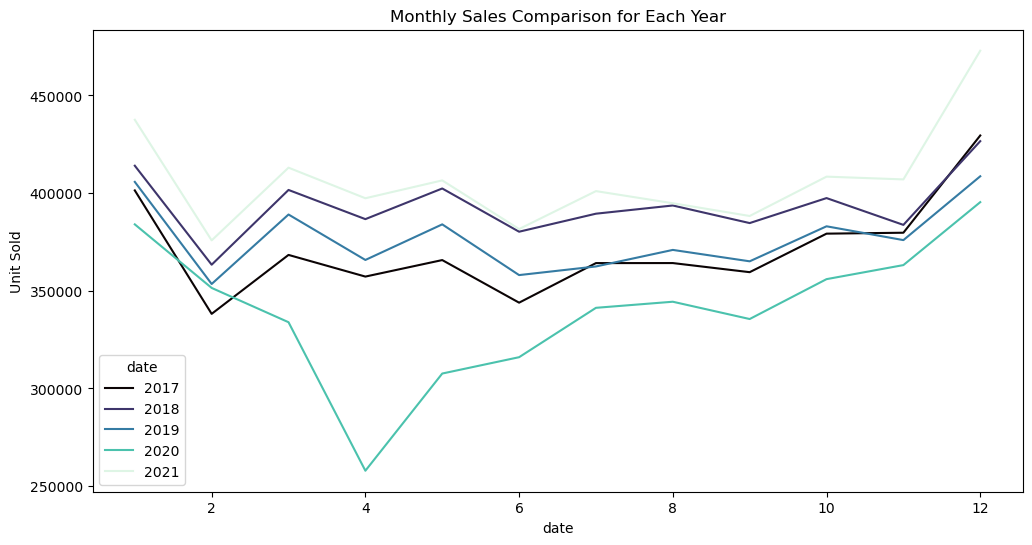

In [7]:
#Plot the monthly-aggregated sales trend over time, compared for each year
plt.figure(figsize=(12,6))
sns.lineplot(x = monthly['date'].dt.month, y = monthly['num_sold'], hue = monthly['date'].dt.year, palette = 'mako')
plt.title('Monthly Sales Comparison for Each Year')
plt.ylabel('Unit Sold')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

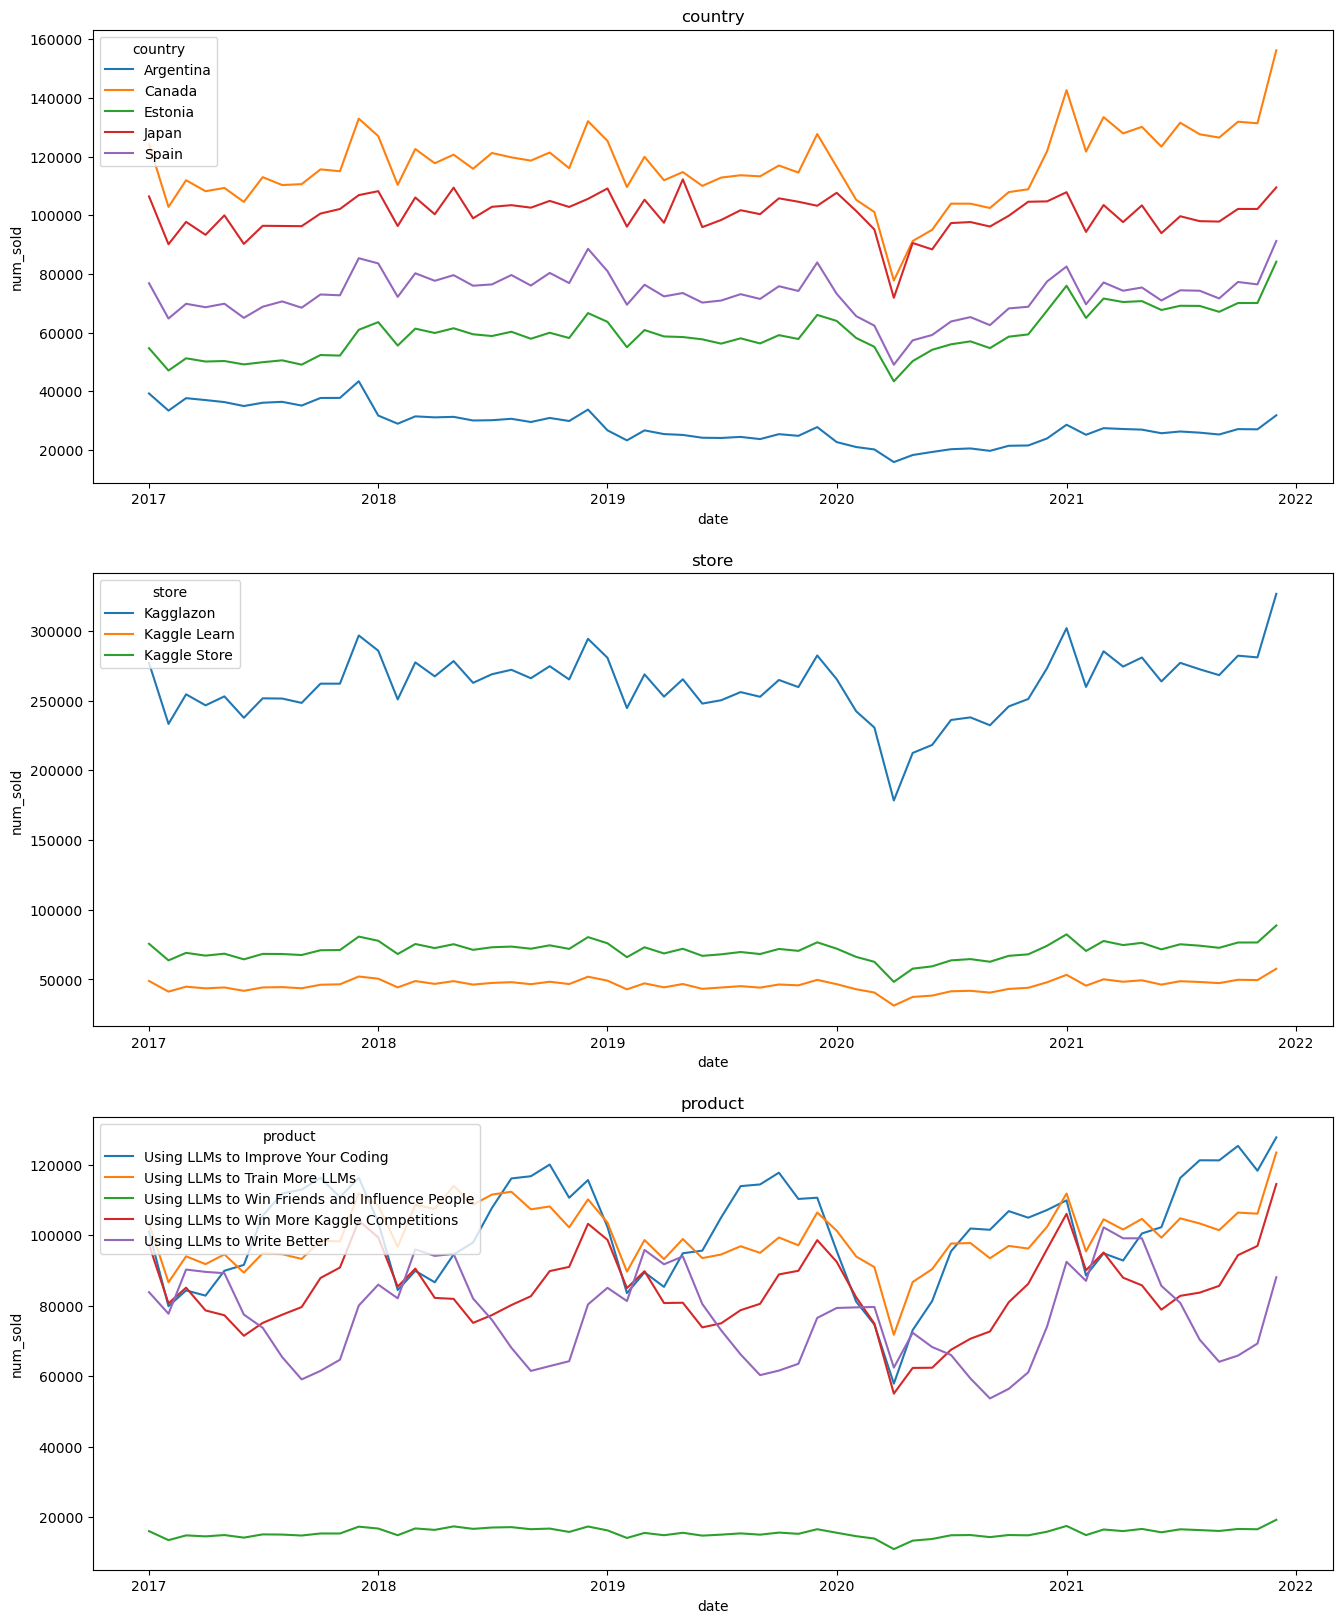

In [8]:
#Plot the monthly-aggregated sales trend over time, comparing for each categories
fig, axs = plt.subplots(3, 1, figsize=(16, 20))
cols = ['country', 'store', 'product']
for i in range(3):
    grouped = df_train.groupby([df_train['date'].dt.to_period('M'), cols[i]]).sum()['num_sold'].reset_index()
    grouped['date'] = grouped['date'].dt.to_timestamp()
    sns.lineplot(x = grouped['date'], y = grouped['num_sold'], hue = grouped[cols[i]], ax=axs[i])
    axs[i].set_title(cols[i])
    sns.move_legend(axs[i], "upper left")
plt.show

# Feature Engineering & Preprocessing

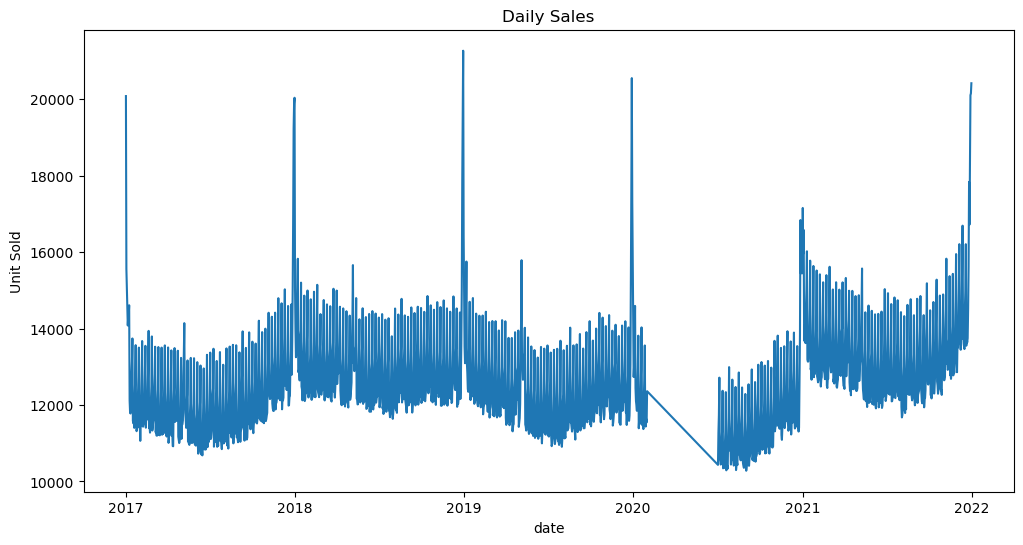

In [28]:
#Discard sales data assumed to be affected by COVID-19 outbreak (Feb-Jul 2020)
train = df_train.loc[~((df_train['date'] >= '2020-02-01') & (df_train['date'] <= '2020-07-01'))].copy()
train = train.groupby('date')['num_sold'].sum().reset_index()
test = df_test.groupby('date').first().reset_index()[['date']]

plt.figure(figsize=(12,6))
sns.lineplot(x = train['date'], y = train['num_sold'])
plt.title('Daily Sales')
plt.ylabel('Unit Sold')
plt.show()

In [10]:
#Define the feature engineering function
def feature_engineering(df):
    data = df.copy()
    
    #Extract year, month, day, and day of the week data from the date variable
    data['year'] = data['date'].dt.year
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['dayweek'] = data['date'].dt.weekday
    
    #Transform using sin & cos (cyclical transformation) for day and month variable
    data["date_sin"] = np.sin(data['day'] * (2 * np.pi / 31))
    data["date_cos"] = np.cos(data['day'] * (2 * np.pi / 31))
    data["month_sin"] = np.sin(data['month'] * (2 * np.pi / 12))
    data["month_cos"] = np.cos(data['month'] * (2 * np.pi / 12))
    
    #Creating a new variable to take into account general international holiday dates
    holiday_dict = holidays.financial_holidays('ECB', years = [2017, 2018, 2019, 2020, 2021, 2022])
    data['holiday'] = data['date'].map(holiday_dict)
    data['holiday'] = data['holiday'].fillna('Not')
    
    #Create a new variable as an indicator of weekend days (presumably friday, saturday, and sunday)
    data['weekends'] = data['dayweek'].apply(lambda x: 'friday' if x == 4 else
                                             ('saturday' if x == 5 else
                                              ('sunday' if x == 6 else 0)))
    
    #Transform categorical variables into dummy binary variable
    data = pd.get_dummies(data, columns = ['holiday', "weekends"])
    
    #Drop unused columns
    data.drop(columns = ['month', 'day', 'dayweek', 'date', 'holiday_Not', 'weekends_0'], inplace = True)
    return data

In [29]:
#Assign X and y variables from dataframe
X_train = train.drop(columns="num_sold")
y_train = train['num_sold']

#Perform the defined feature engineering function
X_train = feature_engineering(X_train)
X_test = feature_engineering(test)

#Standardize X variables by removing the mean and scaling into unit variance
scaler = sklearn.preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

X_train

,year,date_sin,date_cos,month_sin,month_cos,holiday_1 May (Labour Day),holiday_26 December,holiday_Christmas Day,holiday_Easter Monday,holiday_Good Friday,holiday_New Year's Day,weekends_friday,weekends_saturday,weekends_sunday
0,-1.323549,0.280389,1.424113,0.805145,1.172526,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,18.270194,-0.409101,-0.40711,2.450344
1,-1.323549,0.551052,1.337660,0.805145,1.172526,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,-0.054734,-0.409101,-0.40711,-0.408106
2,-1.323549,0.799079,1.197511,0.805145,1.172526,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,-0.054734,-0.409101,-0.40711,-0.408106
3,-1.323549,1.014317,1.009403,0.805145,1.172526,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,-0.054734,-0.409101,-0.40711,-0.408106
4,-1.323549,1.187954,0.781037,0.805145,1.172526,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,-0.054734,-0.409101,-0.40711,-0.408106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1669,1.448576,-1.017971,1.009403,0.090542,1.360986,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,-0.054734,-0.409101,-0.40711,-0.408106
1670,1.448576,-0.802733,1.197511,0.090542,1.360986,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,-0.054734,-0.409101,-0.40711,-0.408106
1671,1.448576,-0.554705,1.337660,0.090542,1.360986,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,-0.054734,-0.409101,-0.40711,-0.408106
1672,1.448576,-0.284043,1.424113,0.090542,1.360986,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,-0.054734,-0.409101,-0.40711,-0.408106


In [12]:
print(X_train.shape)
print(X_test.shape)

(1674, 14)
(365, 14)


# Modeling

## XGBoost

In [13]:
def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

smape_score = sklearn.metrics.make_scorer(smape, greater_is_better = False)

In [ ]:
#Tune the n_estimator with 5-fold CV, with other hyperparameters set fix with their initial values
xgb = XGBRegressor(n_estimators=1000,
                   max_depth=7,
                   eta=0.1,
                   subsample=0.8,
                   colsample_bytree=0.9,
                   seed=15)

xgb_param = xgb.get_xgb_params()
xgtrain = xgboost.DMatrix(X_train.values, label=y_train.values)
cvresult = xgboost.cv(xgb_param, xgtrain, num_boost_round=xgb.get_params()['n_estimators'], nfold=5,
                      metrics='rmse', early_stopping_rounds=150)
xgb.set_params(n_estimators=cvresult.shape[0]) #281 trees

In [ ]:
# Tune max_depth and min_child_weight
param_test = {
 'max_depth':range(3,11,1),
 'min_child_weight':range(1,15,1)
}
gsearch = sklearn.model_selection.GridSearchCV(estimator = XGBRegressor(learning_rate=0.1,
                                                                        n_estimators=281,
                                                                        max_depth=7,
                                                                        min_child_weight=1,
                                                                        subsample=0.8,
                                                                        colsample_bytree=0.9,
                                                                        seed=15),
                                               param_grid = param_test,
                                               scoring=smape_score,
                                               cv=5)

gsearch.fit(X_train.values, y_train.values)
gsearch.best_params_ #{'max_depth': 6, 'min_child_weight': 14}

In [ ]:
#Check the n_estimator with other hyperparameters set fix with their tuned and init. values
xgb = XGBRegressor(n_estimators=2000,
                   max_depth=6,
                   min_child_weight = 14,
                   eta=0.1,
                   subsample=0.8,
                   colsample_bytree=0.9,
                   seed=15)

xgb_param = xgb.get_xgb_params()
xgtrain = xgboost.DMatrix(X_train.values, label=y_train.values)
cvresult = xgboost.cv(xgb_param, xgtrain, num_boost_round=xgb.get_params()['n_estimators'], nfold=5,
                      metrics='rmse', early_stopping_rounds=150)
xgb.set_params(n_estimators=cvresult.shape[0]) #1202 trees

In [ ]:
# Tune subsample and colsample_bytree
param_test = {
    'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1],
}

gsearch = sklearn.model_selection.GridSearchCV(estimator = XGBRegressor(learning_rate=0.1,
                                                                        n_estimators=1202,
                                                                        max_depth=6,
                                                                        min_child_weight=14,
                                                                        subsample=0.8,
                                                                        colsample_bytree=0.9,
                                                                        seed=15),
                                               param_grid = param_test,
                                               scoring=smape_score,
                                               cv=5)

gsearch.fit(X_train.values, y_train.values)
gsearch.best_params_ #{'colsample_bytree': 0.5, 'subsample': 0.5}

In [14]:
#Check the n_estimator with other hyperparameters set fix with their tuned and init. values
xgb = XGBRegressor(n_estimators=5000,
                   max_depth=6,
                   min_child_weight = 14,
                   eta=0.1,
                   subsample=0.5,
                   colsample_bytree=0.5,
                   seed=15)

xgb_param = xgb.get_xgb_params()
xgtrain = xgboost.DMatrix(X_train.values, label=y_train.values)
cvresult = xgboost.cv(xgb_param, xgtrain, num_boost_round=xgb.get_params()['n_estimators'], nfold=5,
                      metrics='rmse', early_stopping_rounds=250)
xgb.set_params(n_estimators=cvresult.shape[0]) #2360 trees

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=14, missing=nan,
             monotone_constraints=None, n_estimators=2360, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [15]:
# Tune regularization factors
param_test = {
    'reg_alpha':[0, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'reg_lambda': [0, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

gsearch = sklearn.model_selection.GridSearchCV(estimator = XGBRegressor(learning_rate=0.1,
                                                                        n_estimators=2360,
                                                                        max_depth=6,
                                                                        min_child_weight=14,
                                                                        subsample=0.5,
                                                                        colsample_bytree=0.5,
                                                                        reg_alpha=0,
                                                                        reg_lambda=0,
                                                                        seed=15),
                                               param_grid = param_test,
                                               scoring=smape_score,
                                               cv=5)

gsearch.fit(X_train.values, y_train.values)
gsearch.best_params_ #{'reg_alpha': 0.001, 'reg_lambda': 0}

{'reg_alpha': 0.001, 'reg_lambda': 0}

In [18]:
#Check the n_estimator with other hyperparameters set fix with their tuned values
xgb = XGBRegressor(n_estimators=100000,
                   max_depth=6,
                   min_child_weight = 14,
                   eta=0.01,
                   subsample=0.5,
                   colsample_bytree=0.5,
                   reg_alpha=0.001,
                   reg_lambda=0,
                   seed=15)

xgb_param = xgb.get_xgb_params()
xgtrain = xgboost.DMatrix(X_train.values, label=y_train.values)
cvresult = xgboost.cv(xgb_param, xgtrain, num_boost_round=xgb.get_params()['n_estimators'], nfold=5,
                      metrics='rmse', early_stopping_rounds=500)
xgb.set_params(n_estimators=cvresult.shape[0]) #25208 trees

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eta=0.01, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=14, missing=nan,
             monotone_constraints=None, n_estimators=25208, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [22]:
#Check the n_estimator with other hyperparameters set fix with their tuned and init. values
xgb = XGBRegressor(n_estimators=25208,
                   max_depth=6,
                   min_child_weight = 14,
                   eta=0.01,
                   subsample=0.5,
                   colsample_bytree=0.5,
                   reg_alpha=0.001,
                   reg_lambda=0,
                   seed=15)

# define model evaluation method
cv = sklearn.model_selection.TimeSeriesSplit(n_splits=5)
# evaluate model
scores = sklearn.model_selection.cross_validate(xgb,
                                                X_train.values,
                                                y_train.values,
                                                scoring=smape_score,
                                                return_train_score=True,
                                                cv=cv)

train_smape_xgb = np.abs(scores['train_score'].mean())
val_smape_xgb = np.abs(scores['test_score'].mean())

print('Training sMAPE: {}%'.format(np.round(train_smape_xgb, 2)))
print('Val sMAPE: {}%'.format(np.round(val_smape_xgb, 2)))

Training sMAPE: 0.75%
Val sMAPE: 4.35%


## Neural Networks

In [56]:
def smape(a, f):
    a = tf.cast(a, dtype='float64')
    f = tf.cast(f, dtype='float64')
    return 1/len(a) * tf.keras.backend.sum(2 * tf.keras.backend.abs(f-a) / (tf.keras.backend.abs(a) + tf.keras.backend.abs(f))*100)

In [33]:
Train = X_train.copy()
Train['num_sold'] = y_train
Train

,year,date_sin,date_cos,month_sin,month_cos,holiday_1 May (Labour Day),holiday_26 December,holiday_Christmas Day,holiday_Easter Monday,holiday_Good Friday,holiday_New Year's Day,weekends_friday,weekends_saturday,weekends_sunday,num_sold
0,-1.323549,0.280389,1.424113,0.805145,1.172526,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,18.270194,-0.409101,-0.40711,2.450344,20086
1,-1.323549,0.551052,1.337660,0.805145,1.172526,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,-0.054734,-0.409101,-0.40711,-0.408106,15563
2,-1.323549,0.799079,1.197511,0.805145,1.172526,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,-0.054734,-0.409101,-0.40711,-0.408106,15039
3,-1.323549,1.014317,1.009403,0.805145,1.172526,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,-0.054734,-0.409101,-0.40711,-0.408106,14516
4,-1.323549,1.187954,0.781037,0.805145,1.172526,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,-0.054734,-0.409101,-0.40711,-0.408106,14083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1669,1.448576,-1.017971,1.009403,0.090542,1.360986,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,-0.054734,-0.409101,-0.40711,-0.408106,16724
1670,1.448576,-0.802733,1.197511,0.090542,1.360986,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,-0.054734,-0.409101,-0.40711,-0.408106,18507
1671,1.448576,-0.554705,1.337660,0.090542,1.360986,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,-0.054734,-0.409101,-0.40711,-0.408106,20110
1672,1.448576,-0.284043,1.424113,0.090542,1.360986,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,-0.054734,-0.409101,-0.40711,-0.408106,20156


In [36]:
Train[1126:]

,year,date_sin,date_cos,month_sin,month_cos,holiday_1 May (Labour Day),holiday_26 December,holiday_Christmas Day,holiday_Easter Monday,holiday_Good Friday,holiday_New Year's Day,weekends_friday,weekends_saturday,weekends_sunday,num_sold
1126,0.755545,0.551052,1.337660,-0.624061,-1.263923,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,-0.054734,-0.409101,-0.407110,-0.408106,10435
1127,0.755545,0.799079,1.197511,-0.624061,-1.263923,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,-0.054734,2.444381,-0.407110,-0.408106,11283
1128,0.755545,1.014317,1.009403,-0.624061,-1.263923,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,-0.054734,-0.409101,2.456341,-0.408106,11742
1129,0.755545,1.187954,0.781037,-0.624061,-1.263923,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,-0.054734,-0.409101,-0.407110,2.450344,12718
1130,0.755545,1.312882,0.521763,-0.624061,-1.263923,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,-0.054734,-0.409101,-0.407110,-0.408106,10607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1669,1.448576,-1.017971,1.009403,0.090542,1.360986,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,-0.054734,-0.409101,-0.407110,-0.408106,16724
1670,1.448576,-0.802733,1.197511,0.090542,1.360986,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,-0.054734,-0.409101,-0.407110,-0.408106,18507
1671,1.448576,-0.554705,1.337660,0.090542,1.360986,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,-0.054734,-0.409101,-0.407110,-0.408106,20110
1672,1.448576,-0.284043,1.424113,0.090542,1.360986,-0.048941,-0.054734,-0.054734,-0.048941,-0.048941,-0.054734,-0.409101,-0.407110,-0.408106,20156


In [63]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=Train[:1126], val_df=Train[1126:], test_df=X_test,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}
        
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)
        
    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    
    return inputs, labels

WindowGenerator.split_window = split_window
    
def make_dataset(self, data):
    data = np.array(data, dtype=np.float64)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    ds = ds.map(self.split_window)
    
    return ds

WindowGenerator.make_dataset = make_dataset
    
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [95]:
MAX_EPOCHS = 500

def compile_and_fit(model, window, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=[smape])
    
    history = model.fit(window.train,
                        epochs = MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    
    return history  

In [105]:
# LABEL_WIDTH = 30
# CONV_WIDTH = 5
# INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
# wide_conv_window = WindowGenerator(
#     input_width=INPUT_WIDTH,
#     label_width=LABEL_WIDTH,
#     shift=1,
#     label_columns= ['num_sold'])

wide_window = WindowGenerator(
    input_width=30, label_width=1, shift=1,
    label_columns=['num_sold'])

In [106]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(2048, return_sequences=True),
    tf.keras.layers.LSTM(1024, return_sequences=True),
    tf.keras.layers.LSTM(512, return_sequences=True),
    tf.keras.layers.LSTM(216, return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64,
                          activation = 'relu',
#                           kernel_regularizer = tf.keras.regularizers.L2(l2=0.01),
#                           bias_regularizer = tf.keras.regularizers.L2(l2=0.01)
                         ),
    tf.keras.layers.Dense(32,
                          activation = 'relu',
#                           kernel_regularizer = tf.keras.regularizers.L2(l2=0.01),
#                           bias_regularizer = tf.keras.regularizers.L2(l2=0.01)
                         ),
    tf.keras.layers.Dense(16,
                          activation = 'relu',
#                           kernel_regularizer = tf.keras.regularizers.L2(l2=0.01),
#                           bias_regularizer = tf.keras.regularizers.L2(l2=0.01)
                         ),
    tf.keras.layers.Dense(1,
                          activation = 'relu',
#                           kernel_regularizer = tf.keras.regularizers.L2(l2=0.01),
#                           bias_regularizer = tf.keras.regularizers.L2(l2=0.01)
                         )
])

history = compile_and_fit(lstm_model, wide_window)

Epoch 1/500
35/35 [==============================] - 207s 5s/step - loss: 12484.6104 - smape: 199.7618 - val_loss: 12871.5771 - val_smape: 199.3241
Epoch 2/500
35/35 [==============================] - 177s 5s/step - loss: 12430.0391 - smape: 197.9750 - val_loss: 12757.4424 - val_smape: 195.7852
Epoch 3/500
35/35 [==============================] - 177s 5s/step - loss: 12195.4414 - smape: 190.5008 - val_loss: 12334.9580 - val_smape: 183.1989
Epoch 4/500
35/35 [==============================] - 176s 5s/step - loss: 11474.6797 - smape: 169.5048 - val_loss: 11190.1660 - val_smape: 152.9786
Epoch 5/500
35/35 [==============================] - 177s 5s/step - loss: 9742.8662 - smape: 127.5720 - val_loss: 8671.4277 - val_smape: 100.8456
Epoch 6/500
35/35 [==============================] - 175s 5s/step - loss: 6230.7827 - smape: 66.5691 - val_loss: 3879.1689 - val_smape: 35.0810
Epoch 7/500
35/35 [==============================] - 175s 5s/step - loss: 1494.7625 - smape: 12.4012 - val_loss: 1093.

In [111]:
val_performance = lstm_model.evaluate(wide_window.val)
val_performance

17/17 [==============================] - 15s 899ms/step - loss: 1211.7137 - smape: 9.4761


[1211.7137451171875, 9.476058959960938]

In [104]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

window_size=30
batch_size=32
shuffle_buffer_size=1000

train_set=windowed_dataset(y_train[:1126],
                           window_size=window_size,
                           batch_size=batch_size,
                           shuffle_buffer=shuffle_buffer_size)

valid_set = windowed_dataset(y_train[1126:],
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer=shuffle_buffer_size)

model=tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                           strides=1,
                           activation="relu",
                           padding='causal',
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(32, activation="relu",
#                           kernel_regularizer = tf.keras.regularizers.L2(l2=0.01),
#                           bias_regularizer = tf.keras.regularizers.L2(l2=0.01)
                         ),
    tf.keras.layers.Dense(1, activation='relu'
#                           kernel_regularizer = tf.keras.regularizers.L2(l2=0.01),
#                           bias_regularizer = tf.keras.regularizers.L2(l2=0.01)
                         )
])

model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=[smape])

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5)
model.fit(train_set, validation_data = valid_set, epochs = 1000, callbacks = [stop_early])

Epoch 1/1000
35/35 [==============================] - 7s 64ms/step - loss: 12487.5088 - smape: 5993.6592 - val_loss: 12735.6807 - val_smape: 5985.5757
Epoch 2/1000
35/35 [==============================] - 1s 39ms/step - loss: 12468.7568 - smape: 5975.5005 - val_loss: 12714.2754 - val_smape: 5965.2847
Epoch 3/1000
35/35 [==============================] - 1s 39ms/step - loss: 12445.7109 - smape: 5953.2979 - val_loss: 12688.9170 - val_smape: 5941.3188
Epoch 4/1000
35/35 [==============================] - 1s 39ms/step - loss: 12417.9121 - smape: 5926.5630 - val_loss: 12658.3691 - val_smape: 5912.8633
Epoch 5/1000
35/35 [==============================] - 1s 38ms/step - loss: 12384.7061 - smape: 5894.8281 - val_loss: 12622.1660 - val_smape: 5879.0166
Epoch 6/1000
35/35 [==============================] - 2s 40ms/step - loss: 12345.7021 - smape: 5857.8384 - val_loss: 12580.0312 - val_smape: 5839.7563
Epoch 7/1000
35/35 [==============================] - 1s 38ms/step - loss: 12300.6914 - smape: